# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import copy
import datetime as dt
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [8]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


##### Cleaning and transforming data

###### portfolio cleaning
- convert channels using one-hot encoding.
- convert offer type using one-hot encoding.
- convert duration from days to hours to be consistent with transcript.

###### profile dataframe cleaning
- replace years 118 with 0
- replace gender female = 0, male = 1, unknown = 2
- replace unknown income to 0
- convert string to datetime, create additional features of day of month, month and year.
- drop columns with datetime string

###### transcript processing
- for each person in the transcript, sort the transcripts record by transaction time.
- if offer is received, then initialise the records
- when offer is viewed, update the "offer viewed" feature from 0 to 1
- when there is transaction, update the running transaction amount.
- when offer is complete, update the "offer completed" from 0 to 1.


In [14]:
class Preprocessor:
    '''
    Preprocessor contains all the methods to transform raw data to clean data.
    
    Processed fields are specificed in the documentation above.
    
    '''
    def __init__(self, portfolio, transcript, profile):
        self.portfolio = portfolio
        self.transcript = transcript
        self.profile = profile
    
    def preprocess_portfolio(self):
        df = self.portfolio.copy(deep=True)
        offers = pd.get_dummies(df['offer_type'])
        ad_medium = df['channels'].map(lambda x: ','.join(map(str, x))).str.get_dummies(sep=',')
        df['duration'] = df['duration']*24 # convert days to hours to tally with the transcript
        df.drop(['channels', 'offer_type'], axis = 1, inplace=True)
        return pd.concat([df, offers, ad_medium], axis=1)

    def preprocess_profile(self):
        df = self.profile.copy(deep=True)
        df['age'] = df['age'].replace(118, 0)
        df['income'] = df['income'].fillna(0)
        df['gender'] = df['gender'].fillna(2)
        df['gender'] = df['gender'].map({'F': 0, 'M':1, 'O':2, 2:2})       
        df['became_member_on'] = [dt.datetime.strptime(str(i),'%Y%m%d').date() for i in profile['became_member_on']]
        df['day'] = [i.day for i in df['became_member_on']]
        df['month'] = [i.month for i in df['became_member_on']]
        df['year'] = [i.year for i in df['became_member_on']]
        df.drop(['became_member_on'], axis=1, inplace=True)
        return df
    
    def preprocess_transcript(self):
        df = self.transcript.copy(deep=True)
        # successful offer: offer received, viewed and completed and within the expiration date
        # attempted offer: offer received, viewed but not completed and out of expiration date
        # failed offer: offer received but not viewed.
        # total amount spent at the time of failed expiry or offer completed
        offer_ids = []
        amounts = []
        # amount_dict = defaultdict(lambda : 0)
        rewards = []
        df = transcript.copy(deep=True)
        for idx in range(len(df)):
            current = df.iloc[idx]
            if 'offer id' in current['value']:
                offer_ids.append(current['value']['offer id'])
            elif 'offer_id' in current['value']:
                offer_ids.append(current['value']['offer_id'])
            else:
                offer_ids.append(np.nan)

            if 'amount' in current['value']:
                amounts.append(current['value']['amount'])
            else:
                amounts.append(0.0)
            if 'reward' in current['value']:
                rewards.append(current['value']['reward'])
            else:
                rewards.append(0.0)

        df['offer_id'] = offer_ids
        df['transactions'] = amounts
        df['rewards_claimed'] = rewards
        df.drop(['value'], axis=1, inplace=True)
        return df
    
    def add_portfolio_info(self, cleaned_transcripts, cleaned_portfolio):
        # helper inner function.
        """
        Check through the transaction dataset, if the amount spend is more than the required amount
        and within the required time then the offer is completed else it is not completed.
        """
        def grab_offer_entries(curr):
            entries = {}
            entries['offer_id'] = curr['offer_id']
            entries['time'] = curr['time']
            entries['expiry'] = curr['expiry']
            entries['total_transactions'] = 0
            entries['offer_viewed'] = 0
            entries['offer_completed'] = 0 
            return entries

        def view_offer_entries(entry):
            entry['offer_viewed'] = 1
            return entry

        def update_offer_entries(entry, transaction):
            entry['total_transactions'] += transaction
            return entry

        def complete_offer_entries(entry):
            entry['offer_completed'] = 1
            return entry
        # main-driver code.
        merged_df = pd.merge(cleaned_transcripts, cleaned_portfolio, left_on='offer_id', right_on='id', how='outer')
        merged_df['expiry'] = merged_df['time'] + merged_df['duration']
        entries = []
        print("starting to add portfolio info")
        for person in merged_df['person'].unique():
            active_offers = {}
            person_rec = merged_df[merged_df['person'] == person].sort_values(["time", 'event'], ascending=[True, False]).copy(deep=True)
            for idx in range(len(person_rec)):
                current = person_rec.iloc[idx]
                if current.loc['event'] == 'offer received':
                    if current.loc['offer_id'] not in active_offers:
                        active_offers[current.loc['offer_id']] = grab_offer_entries(current)
                elif current.loc['event'] == 'offer viewed':
                    if current.loc['offer_id'] not in active_offers:
                        active_offers[current.loc['offer_id']] = grab_offer_entries(current)
                    active_offers[current.loc['offer_id']] = view_offer_entries(active_offers[current.loc['offer_id']])
                elif current.loc['event'] == 'transaction':
                    for offer_id in active_offers:
                        if active_offers[offer_id]['offer_completed'] != 1:
                            active_offers[offer_id] = update_offer_entries(active_offers[offer_id], current.loc['transactions'])
                elif current.loc['event'] == 'offer completed':
                    if current.loc['offer_id'] in active_offers:
                        active_offers[current.loc['offer_id']] = complete_offer_entries(active_offers[current.loc['offer_id']])
            for offer_id in active_offers:
                active_offers[offer_id]['person'] = person
                entries.append(active_offers[offer_id])
        transcript_after_merged = pd.DataFrame(entries)
        transcript_reasonable = transcript_after_merged[['person', 'offer_id','time','expiry', 'total_transactions', 'offer_viewed', 'offer_completed']].copy(deep=True)
        return transcript_reasonable
    
    def generate_master_df(self, portfolio, transcript, profile):
        master_df1 = pd.merge(transcript, portfolio, left_on='offer_id', right_on='id', how='outer')
        master_df = pd.merge(master_df1, profile, left_on='person', right_on='id', how='left')
        master_df = master_df.drop(['id_x', 'id_y'], axis=1)
        return master_df

    def preprocess(self):
        preprocessed_portfolio = self.preprocess_portfolio()
        print('portfolio processing done.')
        preprocessed_profile = self.preprocess_profile()
        print('profile processing done')
        preprocessed_transcript = self.preprocess_transcript() 
        print('transcript processing done.')
        final_transcript = self.add_portfolio_info(preprocessed_transcript, preprocessed_portfolio)
        print('final transcript done')
        return self.generate_master_df(preprocessed_portfolio, final_transcript, preprocessed_profile)
        
        

In [6]:
pp = Preprocessor(portfolio, transcript, profile)
master_df = pp.preprocess()

portfolio processing done.
profile processing done
transcript processing done.
starting to add portfolio info
final transcript done


In [7]:
master_df.head()

,person,offer_id,time,expiry,total_transactions,offer_viewed,offer_completed,difficulty,duration,reward,...,email,mobile,social,web,age,gender,income,day,month,year
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,168.0,19.89,1,1,5,168,5,...,1,1,0,1,75,0,100000.0,9,5,2017
1,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,168.0,52.08,1,0,5,168,5,...,1,1,0,1,59,1,41000.0,21,1,2015
2,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,168.0,5.47,1,1,5,168,5,...,1,1,0,1,40,1,33000.0,9,7,2016
3,c0d210398dee4a0895b24444a5fcd1d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,168.0,6.01,1,1,5,168,5,...,1,1,0,1,45,1,33000.0,7,7,2018
4,57dd18ec5ddc46828afb81ec5977bef2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,168.0,249.40,0,0,5,168,5,...,1,1,0,1,54,0,80000.0,7,2,2017


In [30]:
# transcript_reasonable = transcript_reasonable[['person', 'offer_id','time','expiry', 'total_transactions', 'offer_viewed', 'offer_completed']].copy(deep=True)

In [8]:
master_df.to_csv('data/master_df.csv', index=False)

In [9]:
master_df = pd.read_csv('data/master_df.csv')

In [10]:
# manually map the offer id to more readable names: bogo/reward/difficulty/duration
offer_mappings = {'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo/10/10/168',
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo/10/10/120',
                '3f207df678b143eea3cee63160fa8bed': 'info/0/0/96',
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo/5/5/168',
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount/5/20/240',
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount/3/7/168',
                'fafdcd668e3743c1bb461111dcafc2a4': 'discount/2/10/240',
                '5a8bc65990b245e5a138643cd4eb9837': 'info/0/0/720',
                'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo/5/5/120',
                '2906b810c7d4411798c6938adc9daaa5': 'discount/2/10/168'}

In [11]:
master_df['offer_name'] = master_df['offer_id'].map(offer_mappings)
master_df = master_df.drop('offer_id', axis=1)

In [12]:
# give offer lapse indication:
# if offer is not completed but the total transaction is more than the minimum required to spend.
def identify_expired_offer(df):
    """
    determine if the offer have lapsed by comparing the total transaction is more than the minimum spent
    and offer not completed.
    """
    assert "total_transactions" in df.columns, 'total_transactions column is not in the dataframe'
    assert "offer_completed" in df.columns, 'offer_completed is not in the dataframe'
    assert "difficulty" in df.columns, 'difficulty is not in the dataframe'
    offer_lapse_list = []
    for pos in range(len(df)):
        current = df.iloc[pos]
        if current.loc['total_transactions'] > current.loc['difficulty'] and current.loc['offer_completed'] != 1:
            offer_lapse_list.append(1)
        else:
            offer_lapse_list.append(0)
    df['offer_lapse'] = offer_lapse_list
    return df

In [13]:
master_df = identify_expired_offer(master_df)

In [14]:
master_df.head()

,person,time,expiry,total_transactions,offer_viewed,offer_completed,difficulty,duration,reward,bogo,...,social,web,age,gender,income,day,month,year,offer_name,offer_lapse
0,78afa995795e4d85b5d9ceeca43f5fef,0,168.0,19.89,1,1,5,168,5,1,...,0,1,75,0,100000.0,9,5,2017,bogo/5/5/168,0
1,ebe7ef46ea6f4963a7dd49f501b26779,0,168.0,52.08,1,0,5,168,5,1,...,0,1,59,1,41000.0,21,1,2015,bogo/5/5/168,1
2,f082d80f0aac47a99173ba8ef8fc1909,0,168.0,5.47,1,1,5,168,5,1,...,0,1,40,1,33000.0,9,7,2016,bogo/5/5/168,0
3,c0d210398dee4a0895b24444a5fcd1d2,0,168.0,6.01,1,1,5,168,5,1,...,0,1,45,1,33000.0,7,7,2018,bogo/5/5/168,0
4,57dd18ec5ddc46828afb81ec5977bef2,0,168.0,249.40,0,0,5,168,5,1,...,0,1,54,0,80000.0,7,2,2017,bogo/5/5/168,1


Text(0.5,1,'offer viewed')

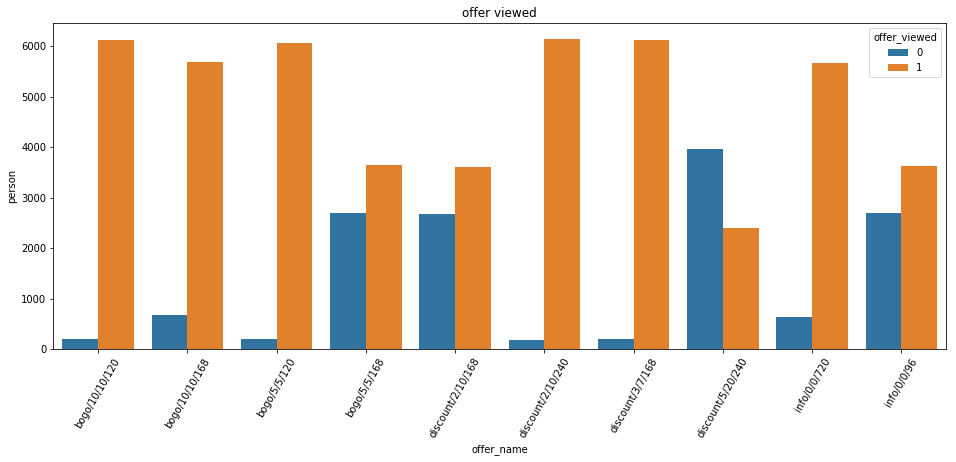

In [17]:
ax=plt.figure(figsize=(16,6))
plotdf = master_df.groupby(['offer_name', 'offer_viewed']).count()['person'].to_frame().reset_index()
sns.barplot(data=plotdf, x='offer_name', y='person', hue='offer_viewed')
plt.xticks(rotation=60)
plt.title("offer viewed")

Text(0.5,1,'offer completed')

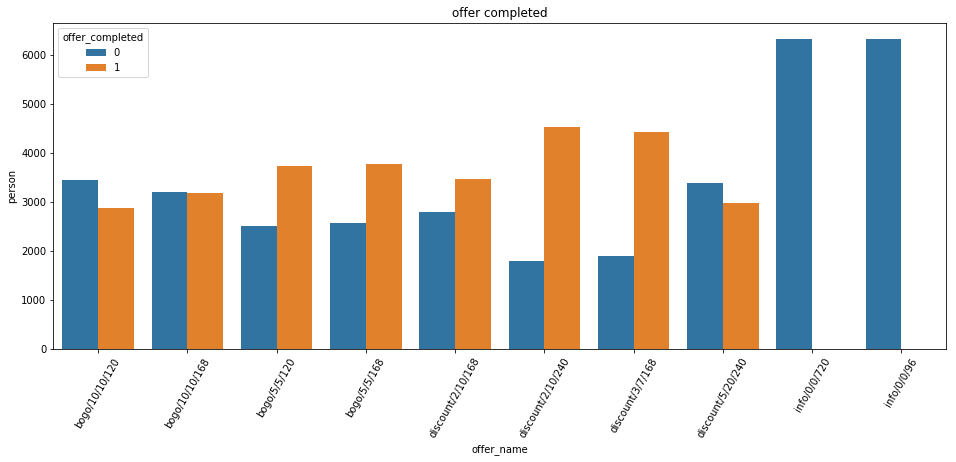

In [18]:
ax=plt.figure(figsize=(16,6))
plotdf = master_df.groupby(['offer_name', 'offer_completed']).count()['person'].to_frame().reset_index()
sns.barplot(data=plotdf, x='offer_name', y='person', hue='offer_completed')
plt.xticks(rotation=60)
plt.title("offer completed")

Text(0.5,1,'income category and whether offer is completed.')

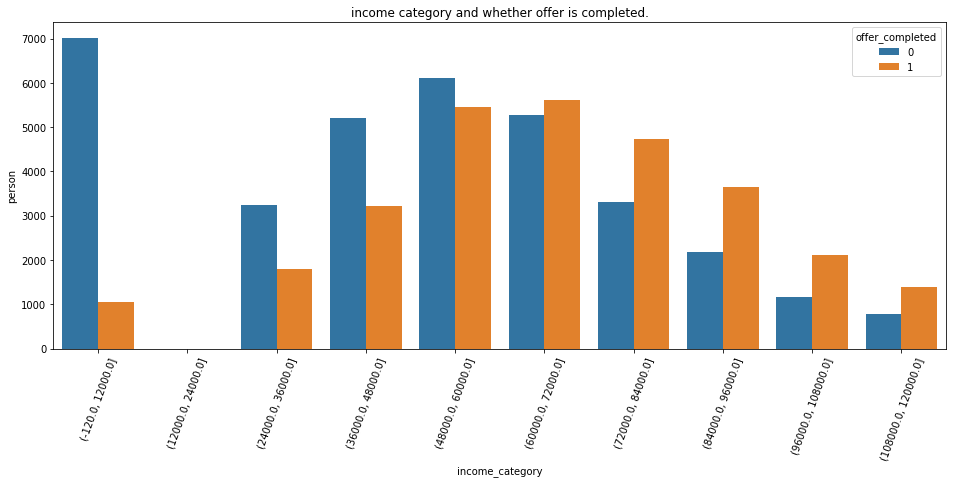

In [19]:
ax=plt.figure(figsize=(16,6))
income_df = master_df.copy(deep=True)
income_df['income_category'] = pd.cut(income_df['income'],bins=10)
income_df_cat = income_df.groupby(['income_category', 'offer_completed']).count()['person'].to_frame().reset_index()
plt.xticks(rotation=70)
sns.barplot(data=income_df_cat, x='income_category', y='person', hue='offer_completed')
plt.title("income category and whether offer is completed.")

Text(0.5,1,'age group and offer completed.')

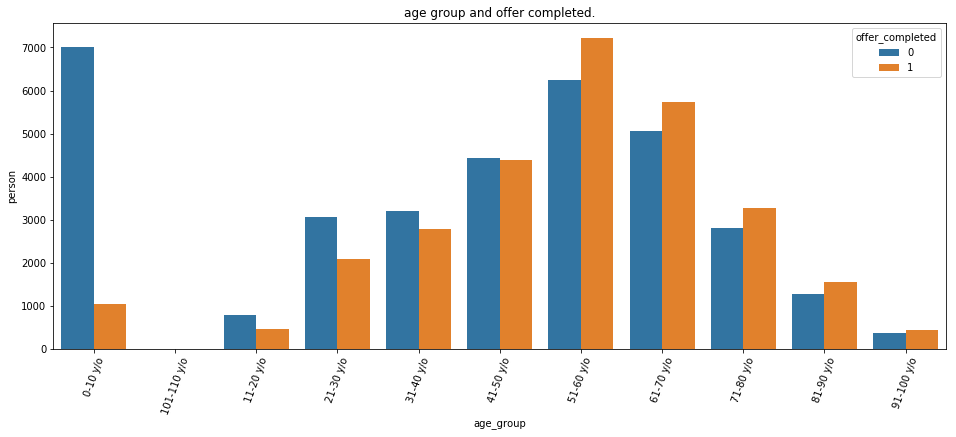

In [20]:
def create_age_group(df):
    age_df = df.copy(deep=True)
    age_list = []
    for idx in range(len(age_df)):
        current = age_df.iloc[idx]
        if current.loc['age']>=0 and current.loc['age'] <=10:
            age_list.append('0-10 y/o')
        elif current.loc['age']>=11 and current.loc['age'] <=20:
            age_list.append('11-20 y/o')
        elif current.loc['age']>=21 and current.loc['age'] <=30:
            age_list.append('21-30 y/o')
        elif current.loc['age']>=31 and current.loc['age'] <=40:
            age_list.append('31-40 y/o')
        elif current.loc['age']>=41 and current.loc['age'] <=50:
            age_list.append('41-50 y/o')
        elif current.loc['age']>=51 and current.loc['age'] <=60:
            age_list.append('51-60 y/o')
        elif current.loc['age']>=61 and current.loc['age'] <=70:
            age_list.append('61-70 y/o')
        elif current.loc['age']>=71 and current.loc['age'] <=80:
            age_list.append('71-80 y/o')
        elif current.loc['age']>=81 and current.loc['age'] <=90:
            age_list.append('81-90 y/o')
        elif current.loc['age']>=91 and current.loc['age'] <=100:
            age_list.append('91-100 y/o')
        elif current.loc['age']>=101 and current.loc['age'] <=110:
            age_list.append('101-110 y/o')
        elif current.loc['age']>=111 and current.loc['age'] <=120:
            age_list.append('> 111 y/o')
    age_df['age_group'] = age_list
    return age_df
            
ax=plt.figure(figsize=(16,6))
age_df = create_age_group(master_df.copy(deep=True))
age_df_cat = age_df.groupby(['age_group', 'offer_completed']).count()['person'].to_frame().reset_index()
plt.xticks(rotation=70)
sns.barplot(data=age_df_cat, x='age_group', y='person', hue='offer_completed')
plt.title('age group and offer completed.')

Text(0.5,1,'offer completed segemented by year')

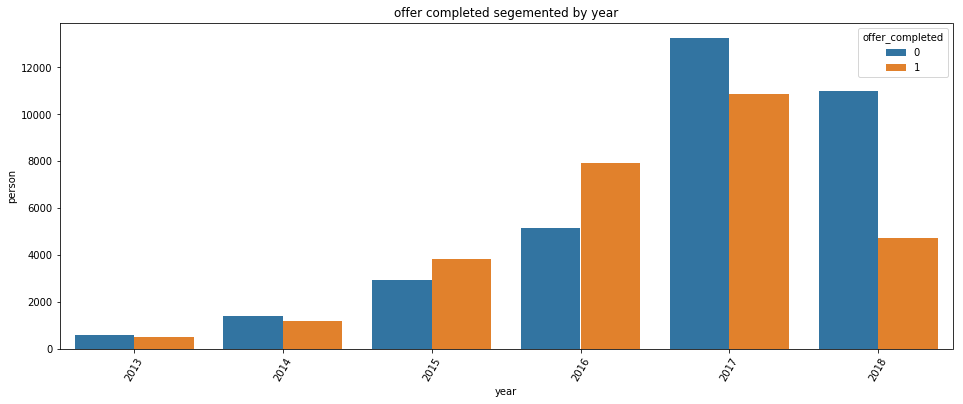

In [21]:
# does the year in which the user becomes the member shows a trend in completing the offer.
ax=plt.figure(figsize=(16,6))
plotdf = master_df.groupby(['year', 'offer_completed']).count()['person'].to_frame().reset_index()
sns.barplot(data=plotdf, x='year', y='person', hue='offer_completed')
plt.xticks(rotation=60)
plt.title("offer completed segemented by year")

##### problem statement: 
- identify which demographics of people are most responsive to each BOGO offer/ discount offer with their offer completed.

##### data exploratory conclusion:
- using the final processed dataset, exploratory data analysis is done which could reveal some practical insights.


##### modelling the problem:
- the problem can be modelled by a binary classification problem.
- several model will be used:
    - logistic classifier (default has ridge capability.)
    - lasso classifier
    - simple decision tree classifier
    - random forest tree classifier
    - adaboost tree classifier.

##### Some metric to compare across model:
- accuracy
- f1-score
- precision
- recall

##### Using GridSearch to find local optimal solution

##### modelling conclusion
- what could be explored further? Grid Search may not be the global optimal. Using PSO could be used to improve the model's metric find finding the global optimal hyper parameters.

In [23]:
# selecting offer completed dataset for ml
def prep_for_ml(df, y_label='offer_completed'):
    bogo_discount_df = df[df['informational']!=1].copy(deep=True)
    X_data = bogo_discount_df[['total_transactions','difficulty','duration','reward','bogo','discount',
                               'email','mobile','social', 'web', 'age', 'gender', 'income',
                              'day','month','year']]
    y_data = bogo_discount_df['offer_completed']
    return X_data, y_data

In [24]:
X_data, y_data = prep_for_ml(master_df, 'offer_completed')

In [27]:
y_data.value_counts()

1    28996
0    21641
Name: offer_completed, dtype: int64

In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score,fbeta_score, precision_score

In [33]:
class ClassifierSelector:
    def __init__(self, X, y, model):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=6969)
        self.model = self.initialise_model(model)
        self.fitted_model = None
        self.hyper_params = None
        
    def initialise_model(self, name):
        self.name = name
        if name == "logistic":
            return LogisticRegression(solver = "liblinear")
        elif name == "lasso":
            return LogisticRegression(penalty="l1")
        elif name == 'randomForest':
            return RandomForestClassifier()
        elif name == "adaboost":
            return AdaBoostClassifier()
        elif name == "decisionTree":
            return DecisionTreeClassifier()
        
    def update_hyperparameters(self, params_dict):
        self.hyper_params = params_dict
        
    def train(self):
        '''
        for generic training purpose.
        '''
        self.fitted_model = self.model.fit(self.X_train, self.y_train)
    
    def generate_predictions(self):
        if self.fitted_model is not None:
            y_predicted = self.fitted_model.predict(self.X_test)
            self.y_pred = y_predicted
            return y_predicted
        else:
            print("the model has not been fitted yet, please check.")
            return None
    
    def metrics(self):
        scores = [accuracy_score(self.y_test, self.y_pred),
                    recall_score(self.y_test, self.y_pred),
                    precision_score(self.y_test, self.y_pred),
                    f1_score(self.y_test, self.y_pred),
                    fbeta_score(self.y_test, self.y_pred, beta=2.0)]
        return pd.DataFrame([scores], 
                            columns=['accuracy', 'recall', 'precision', 'f1-score', 'f2-score'], 
                            index=[self.name])
    
    
    def best_model(self):
        if self.hyper_params is not None:
            clf = GridSearchCV(self.model, self.hyper_params, cv=5, verbose=3)
            clf.fit(self.X_train, self.y_train)
            self.return_best_model(clf.best_params_)
            
    def return_best_model(self, best_params):
        """
        update the hyper-parameters obtained from hyper-parameters tuning.
        """
        if self.name == "logistic":
            self.model.solver = best_params["solver"]
            self.model.C = best_params['C']
            self.model.max_iter = best_params['max_iter']
        elif self.name == "lasso":
            self.model.C = best_params['C']
            self.model.max_iter = best_params['max_iter']
        elif self.name == "decisionTree":
            self.model.criterion = best_params['criterion']
            self.model.splitter = best_params['splitter']
            self.model.max_depth = best_params['max_depth']
            self.model.min_samples_split = best_params['min_samples_split']
            self.model.max_features = best_params['max_features']
        elif self.name == "randomForest": 
            self.model.max_features = best_params["max_features"]
            self.model.n_estimators = best_params["n_estimators"]
        elif self.name == "adaboost": 
            self.model.n_estimators = best_params["n_estimators"]
            self.model.learning_rate = best_params["learning_rate"]
        
        

In [44]:
#  if name == "logistic":
#             return LogisticRegression(solver = "liblinear")
#         elif name == "lasso":
#             return LogisticRegression(penalty="l1")
#         elif name == 'randomForest':
#             return RandomForestClassifier()
#         elif name == "adaboost":
#             return adaBoostClassifier()
#         elif name == "decisionTree":
#             return DecisionTreeClassifier()

In [45]:
hyperparameters = {'logistic': {
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "C" : [1, 0.1, 0.01],
    "max_iter": [10, 100, ]
}, 'lasso': {
    "C" : [1, 0.1, 0.01],
    "max_iter": [10, 100 ]
}, "decisionTree": {
    "criterion" : ['gini', 'entropy'],
    "splitter" : ["best", "random"], 
    "max_depth" : [2, 3,4,5, 10],
    "min_samples_split" : [2 , 4, 6, 8, 10], 
    "max_features": ["auto","sqrt", "log2", None]
}, "randomForest": {
    "max_features": [3, 5, 9, 11, "sqrt", "log2"],
    "n_estimators": [10, 100]
}, "adaboost": {
    "n_estimators": [10, 50, 100],
    "learning_rate" : [0.001,0.1,1,10]
}}

In [46]:
# main loop to run the fitting of the model.
evaluation_list = []
best_models = []
for model in ['logistic','lasso', 'decisionTree', 'randomForest', 'adaboost']:
# for model in ['randomForest']:
    print(f"fitting for model {model}")
    cs = ClassifierSelector(X_data,y_data, model)
    cs.update_hyperparameters(hyperparameters[model])
    # obtain the grid search best model.
    cs.best_model()
    best_models.append(cs.model)
    # train the best model again
    cs.train()
    # generates the prediction
    y_pred = cs.generate_predictions()
    # compute the evaluation scores for such matrix
    evaluation = cs.metrics()
    evaluation_list.append(evaluation)
    print(f"done for model {model}")
# combine all the model evaluation metrics.
all_models_evaluation = pd.concat(evaluation_list)

fitting for model logistic
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] C=1, max_iter=10, solver=newton-cg ..............................
[CV]  C=1, max_iter=10, solver=newton-cg, score=0.6788843638158707, total=   0.2s
[CV] C=1, max_iter=10, solver=newton-cg ..............................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  C=1, max_iter=10, solver=newton-cg, score=0.6704924102184376, total=   0.2s
[CV] C=1, max_iter=10, solver=newton-cg ..............................
[CV]  C=1, max_iter=10, solver=newton-cg, score=0.6722626836193063, total=   0.2s
[CV] C=1, max_iter=10, solver=newton-cg ..............................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=1, max_iter=10, solver=newton-cg, score=0.6732502160227133, total=   0.2s
[CV] C=1, max_iter=10, solver=newton-cg ..............................
[CV]  C=1, max_iter=10, solver=newton-cg, score=0.6757190470312308, total=   0.2s
[CV] C=1, max_iter=10, solver=lbfgs ..................................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=1, max_iter=10, solver=lbfgs, score=0.6766629643341973, total=   0.1s
[CV] C=1, max_iter=10, solver=lbfgs ..................................
[CV]  C=1, max_iter=10, solver=lbfgs, score=0.6693817104776009, total=   0.1s
[CV] C=1, max_iter=10, solver=lbfgs ..................................
[CV]  C=1, max_iter=10, solver=lbfgs, score=0.6736205406739909, total=   0.1s
[CV] C=1, max_iter=10, solver=lbfgs ..................................
[CV]  C=1, max_iter=10, solver=lbfgs, score=0.6747315146278238, total=   0.1s
[CV] C=1, max_iter=10, solver=lbfgs ..................................
[CV]  C=1, max_iter=10, solver=lbfgs, score=0.672509566720158, total=   0.1s
[CV] C=1, max_iter=10, solver=liblinear ..............................
[CV]  C=1, max_iter=10, solver=liblinear, score=0.6793780081451314, total=   0.2s
[CV] C=1, max_iter=10, solver=liblinear ..............................
[CV]  C=1, max_iter=10, solver=liblinear, score=0.6730840429470566, total=   0.1s
[CV] C=1, max_iter=10

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=10, solver=sag, score=0.6691348883129705, total=   0.2s
[CV] C=1, max_iter=10, solver=sag ....................................
[CV]  C=1, max_iter=10, solver=sag, score=0.6730033329218615, total=   0.2s
[CV] C=1, max_iter=10, solver=sag ....................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=10, solver=sag, score=0.6742377484261203, total=   0.2s
[CV] C=1, max_iter=10, solver=sag ....................................
[CV]  C=1, max_iter=10, solver=sag, score=0.6731267744722874, total=   0.2s
[CV] C=1, max_iter=10, solver=saga ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=10, solver=saga, score=0.6744415648525237, total=   0.2s
[CV] C=1, max_iter=10, solver=saga ...................................
[CV]  C=1, max_iter=10, solver=saga, score=0.6683944218190794, total=   0.2s
[CV] C=1, max_iter=10, solver=saga ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=10, solver=saga, score=0.6732502160227133, total=   0.2s
[CV] C=1, max_iter=10, solver=saga ...................................
[CV]  C=1, max_iter=10, solver=saga, score=0.6743611899765461, total=   0.2s
[CV] C=1, max_iter=10, solver=saga ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=10, solver=saga, score=0.6730033329218615, total=   0.2s
[CV] C=1, max_iter=100, solver=newton-cg .............................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=newton-cg, score=0.7075157349129952, total=   3.6s
[CV] C=1, max_iter=100, solver=newton-cg .............................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=newton-cg, score=0.7059113908428977, total=   3.8s
[CV] C=1, max_iter=100, solver=newton-cg .............................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=newton-cg, score=0.7079372916923836, total=   3.8s
[CV] C=1, max_iter=100, solver=newton-cg .............................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=newton-cg, score=0.7037402789779039, total=   3.8s
[CV] C=1, max_iter=100, solver=newton-cg .............................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=newton-cg, score=0.7170719664238983, total=   3.7s
[CV] C=1, max_iter=100, solver=lbfgs .................................
[CV]  C=1, max_iter=100, solver=lbfgs, score=0.6792545970628162, total=   0.2s
[CV] C=1, max_iter=100, solver=lbfgs .................................
[CV]  C=1, max_iter=100, solver=lbfgs, score=0.6728372207824262, total=   0.2s
[CV] C=1, max_iter=100, solver=lbfgs .................................
[CV]  C=1, max_iter=100, solver=lbfgs, score=0.6959634613010739, total=   0.4s
[CV] C=1, max_iter=100, solver=lbfgs .................................
[CV]  C=1, max_iter=100, solver=lbfgs, score=0.691025799284039, total=   0.4s
[CV] C=1, max_iter=100, solver=lbfgs .................................
[CV]  C=1, max_iter=100, solver=lbfgs, score=0.6931243056412788, total=   0.4s
[CV] C=1, max_iter=100, solver=liblinear .............................
[CV]  C=1, max_iter=100, solver=liblinear, score=0.6815994076268049, total=   0.2s
[CV] C=1, max_

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=sag, score=0.6761693200049365, total=   1.7s
[CV] C=1, max_iter=100, solver=sag ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=sag, score=0.6699987658891768, total=   1.7s
[CV] C=1, max_iter=100, solver=sag ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=sag, score=0.6721392420688804, total=   1.6s
[CV] C=1, max_iter=100, solver=sag ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=sag, score=0.6746080730773979, total=   1.6s
[CV] C=1, max_iter=100, solver=sag ...................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=sag, score=0.6746080730773979, total=   1.6s
[CV] C=1, max_iter=100, solver=saga ..................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=saga, score=0.6760459089226213, total=   1.7s
[CV] C=1, max_iter=100, solver=saga ..................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=saga, score=0.6692582993952857, total=   1.7s
[CV] C=1, max_iter=100, solver=saga ..................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=saga, score=0.673497099123565, total=   1.6s
[CV] C=1, max_iter=100, solver=saga ..................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=saga, score=0.6743611899765461, total=   1.6s
[CV] C=1, max_iter=100, solver=saga ..................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=1, max_iter=100, solver=saga, score=0.6741143068756944, total=   1.7s
[CV] C=0.1, max_iter=10, solver=newton-cg ............................
[CV]  C=0.1, max_iter=10, solver=newton-cg, score=0.6788843638158707, total=   0.2s
[CV] C=0.1, max_iter=10, solver=newton-cg ............................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.1, max_iter=10, solver=newton-cg, score=0.6704924102184376, total=   0.2s
[CV] C=0.1, max_iter=10, solver=newton-cg ............................
[CV]  C=0.1, max_iter=10, solver=newton-cg, score=0.6722626836193063, total=   0.2s
[CV] C=0.1, max_iter=10, solver=newton-cg ............................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.1, max_iter=10, solver=newton-cg, score=0.6732502160227133, total=   0.2s
[CV] C=0.1, max_iter=10, solver=newton-cg ............................
[CV]  C=0.1, max_iter=10, solver=newton-cg, score=0.6757190470312308, total=   0.2s
[CV] C=0.1, max_iter=10, solver=lbfgs ................................
[CV]  C=0.1, max_iter=10, solver=lbfgs, score=0.6766629643341973, total=   0.1s
[CV] C=0.1, max_iter=10, solver=lbfgs ................................
[CV]  C=0.1, max_iter=10, solver=lbfgs, score=0.6693817104776009, total=   0.1s
[CV] C=0.1, max_iter=10, solver=lbfgs ................................
[CV]  C=0.1, max_iter=10, solver=lbfgs, score=0.6736205406739909, total=   0.1s
[CV] C=0.1, max_iter=10, solver=lbfgs ................................
[CV]  C=0.1, max_iter=10, solver=lbfgs, score=0.6747315146278238, total=   0.1s
[CV] C=0.1, max_iter=10, solver=lbfgs ................................
[CV]  C=0.1, max_iter=10, solver=lbfgs, score=0.672509566720158, total=   0.1s
[CV] C=

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=10, solver=sag, score=0.6687646550660249, total=   0.2s
[CV] C=0.1, max_iter=10, solver=sag ..................................
[CV]  C=0.1, max_iter=10, solver=sag, score=0.6738674237748427, total=   0.2s
[CV] C=0.1, max_iter=10, solver=sag ..................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=10, solver=sag, score=0.6753487223799531, total=   0.2s
[CV] C=0.1, max_iter=10, solver=sag ..................................
[CV]  C=0.1, max_iter=10, solver=sag, score=0.6730033329218615, total=   0.2s
[CV] C=0.1, max_iter=10, solver=saga .................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=10, solver=saga, score=0.6744415648525237, total=   0.2s
[CV] C=0.1, max_iter=10, solver=saga .................................
[CV]  C=0.1, max_iter=10, solver=saga, score=0.6683944218190794, total=   0.2s
[CV] C=0.1, max_iter=10, solver=saga .................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=10, solver=saga, score=0.6731267744722874, total=   0.2s
[CV] C=0.1, max_iter=10, solver=saga .................................
[CV]  C=0.1, max_iter=10, solver=saga, score=0.6742377484261203, total=   0.2s
[CV] C=0.1, max_iter=10, solver=saga .................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=10, solver=saga, score=0.6730033329218615, total=   0.2s
[CV] C=0.1, max_iter=100, solver=newton-cg ...........................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=newton-cg, score=0.7077625570776256, total=   4.0s
[CV] C=0.1, max_iter=100, solver=newton-cg ...........................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=newton-cg, score=0.7051709243490065, total=   3.8s
[CV] C=0.1, max_iter=100, solver=newton-cg ...........................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=newton-cg, score=0.7071966423898284, total=   3.9s
[CV] C=0.1, max_iter=100, solver=newton-cg ...........................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=newton-cg, score=0.7037402789779039, total=   3.6s
[CV] C=0.1, max_iter=100, solver=newton-cg ...........................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=newton-cg, score=0.723120602394766, total=   3.6s
[CV] C=0.1, max_iter=100, solver=lbfgs ...............................
[CV]  C=0.1, max_iter=100, solver=lbfgs, score=0.6792545970628162, total=   0.2s
[CV] C=0.1, max_iter=100, solver=lbfgs ...............................
[CV]  C=0.1, max_iter=100, solver=lbfgs, score=0.6728372207824262, total=   0.2s
[CV] C=0.1, max_iter=100, solver=lbfgs ...............................
[CV]  C=0.1, max_iter=100, solver=lbfgs, score=0.6869522281199852, total=   0.4s
[CV] C=0.1, max_iter=100, solver=lbfgs ...............................
[CV]  C=0.1, max_iter=100, solver=lbfgs, score=0.6930008640908529, total=   0.4s
[CV] C=0.1, max_iter=100, solver=lbfgs ...............................
[CV]  C=0.1, max_iter=100, solver=lbfgs, score=0.7033699543266263, total=   0.4s
[CV] C=0.1, max_iter=100, solver=liblinear ...........................
[CV]  C=0.1, max_iter=100, solver=liblinear, score=0.6817228187091201, total=   0.2s


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=sag, score=0.6760459089226213, total=   1.5s
[CV] C=0.1, max_iter=100, solver=sag .................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=sag, score=0.6698753548068617, total=   1.7s
[CV] C=0.1, max_iter=100, solver=sag .................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=sag, score=0.6722626836193063, total=   1.6s
[CV] C=0.1, max_iter=100, solver=sag .................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=sag, score=0.674484631526972, total=   1.6s
[CV] C=0.1, max_iter=100, solver=sag .................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=sag, score=0.6746080730773979, total=   1.6s
[CV] C=0.1, max_iter=100, solver=saga ................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=saga, score=0.6760459089226213, total=   1.7s
[CV] C=0.1, max_iter=100, solver=saga ................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=saga, score=0.6692582993952857, total=   1.6s
[CV] C=0.1, max_iter=100, solver=saga ................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=saga, score=0.673497099123565, total=   1.6s
[CV] C=0.1, max_iter=100, solver=saga ................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=saga, score=0.6742377484261203, total=   1.7s
[CV] C=0.1, max_iter=100, solver=saga ................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.1, max_iter=100, solver=saga, score=0.6742377484261203, total=   1.7s
[CV] C=0.01, max_iter=10, solver=newton-cg ...........................
[CV]  C=0.01, max_iter=10, solver=newton-cg, score=0.6788843638158707, total=   0.1s
[CV] C=0.01, max_iter=10, solver=newton-cg ...........................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.01, max_iter=10, solver=newton-cg, score=0.6704924102184376, total=   0.2s
[CV] C=0.01, max_iter=10, solver=newton-cg ...........................
[CV]  C=0.01, max_iter=10, solver=newton-cg, score=0.6722626836193063, total=   0.2s
[CV] C=0.01, max_iter=10, solver=newton-cg ...........................


/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.01, max_iter=10, solver=newton-cg, score=0.6732502160227133, total=   0.2s
[CV] C=0.01, max_iter=10, solver=newton-cg ...........................
[CV]  C=0.01, max_iter=10, solver=newton-cg, score=0.6757190470312308, total=   0.2s
[CV] C=0.01, max_iter=10, solver=lbfgs ...............................
[CV]  C=0.01, max_iter=10, solver=lbfgs, score=0.6766629643341973, total=   0.1s
[CV] C=0.01, max_iter=10, solver=lbfgs ...............................
[CV]  C=0.01, max_iter=10, solver=lbfgs, score=0.6693817104776009, total=   0.1s
[CV] C=0.01, max_iter=10, solver=lbfgs ...............................
[CV]  C=0.01, max_iter=10, solver=lbfgs, score=0.6736205406739909, total=   0.1s
[CV] C=0.01, max_iter=10, solver=lbfgs ...............................
[CV]  C=0.01, max_iter=10, solver=lbfgs, score=0.6747315146278238, total=   0.1s
[CV] C=0.01, max_iter=10, solver=lbfgs ...............................
[CV]  C=0.01, max_iter=10, solver=lbfgs, score=0.672509566720158, total=   0.1s


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=10, solver=sag, score=0.6674071331605578, total=   0.2s
[CV] C=0.01, max_iter=10, solver=sag .................................
[CV]  C=0.01, max_iter=10, solver=sag, score=0.6730033329218615, total=   0.2s
[CV] C=0.01, max_iter=10, solver=sag .................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=10, solver=sag, score=0.6752252808295273, total=   0.2s
[CV] C=0.01, max_iter=10, solver=sag .................................
[CV]  C=0.01, max_iter=10, solver=sag, score=0.6743611899765461, total=   0.2s
[CV] C=0.01, max_iter=10, solver=saga ................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=10, solver=saga, score=0.6744415648525237, total=   0.2s
[CV] C=0.01, max_iter=10, solver=saga ................................
[CV]  C=0.01, max_iter=10, solver=saga, score=0.6683944218190794, total=   0.2s
[CV] C=0.01, max_iter=10, solver=saga ................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=10, solver=saga, score=0.6731267744722874, total=   0.2s
[CV] C=0.01, max_iter=10, solver=saga ................................
[CV]  C=0.01, max_iter=10, solver=saga, score=0.6742377484261203, total=   0.2s

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



[CV] C=0.01, max_iter=10, solver=saga ................................
[CV]  C=0.01, max_iter=10, solver=saga, score=0.6730033329218615, total=   0.2s
[CV] C=0.01, max_iter=100, solver=newton-cg ..........................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=newton-cg, score=0.7118351227940269, total=   3.8s
[CV] C=0.01, max_iter=100, solver=newton-cg ..........................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=newton-cg, score=0.7110946563001358, total=   3.8s
[CV] C=0.01, max_iter=100, solver=newton-cg ..........................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=newton-cg, score=0.705591902234292, total=   3.7s
[CV] C=0.01, max_iter=100, solver=newton-cg ..........................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=newton-cg, score=0.708554499444513, total=   3.8s
[CV] C=0.01, max_iter=100, solver=newton-cg ..........................


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=newton-cg, score=0.7255894334032835, total=   3.6s
[CV] C=0.01, max_iter=100, solver=lbfgs ..............................
[CV]  C=0.01, max_iter=100, solver=lbfgs, score=0.6792545970628162, total=   0.2s
[CV] C=0.01, max_iter=100, solver=lbfgs ..............................
[CV]  C=0.01, max_iter=100, solver=lbfgs, score=0.6728372207824262, total=   0.2s
[CV] C=0.01, max_iter=100, solver=lbfgs ..............................
[CV]  C=0.01, max_iter=100, solver=lbfgs, score=0.6952228119985187, total=   0.6s
[CV] C=0.01, max_iter=100, solver=lbfgs ..............................
[CV]  C=0.01, max_iter=100, solver=lbfgs, score=0.6930008640908529, total=   0.4s
[CV] C=0.01, max_iter=100, solver=lbfgs ..............................
[CV]  C=0.01, max_iter=100, solver=lbfgs, score=0.6934946302925564, total=   0.5s
[CV] C=0.01, max_iter=100, solver=liblinear ..........................
[CV]  C=0.01, max_iter=100, solver=liblinear, score=0.6817228187091201, total=

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=sag, score=0.6761693200049365, total=   1.6s
[CV] C=0.01, max_iter=100, solver=sag ................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=sag, score=0.6699987658891768, total=   1.7s
[CV] C=0.01, max_iter=100, solver=sag ................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=sag, score=0.6721392420688804, total=   1.6s
[CV] C=0.01, max_iter=100, solver=sag ................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=sag, score=0.6743611899765461, total=   1.6s
[CV] C=0.01, max_iter=100, solver=sag ................................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=sag, score=0.6746080730773979, total=   1.6s
[CV] C=0.01, max_iter=100, solver=saga ...............................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=saga, score=0.6760459089226213, total=   1.7s
[CV] C=0.01, max_iter=100, solver=saga ...............................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=saga, score=0.6692582993952857, total=   1.7s
[CV] C=0.01, max_iter=100, solver=saga ...............................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=saga, score=0.6733736575731392, total=   1.7s
[CV] C=0.01, max_iter=100, solver=saga ...............................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=0.01, max_iter=100, solver=saga, score=0.6742377484261203, total=   1.7s
[CV] C=0.01, max_iter=100, solver=saga ...............................


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.1min finished


[CV]  C=0.01, max_iter=100, solver=saga, score=0.6741143068756944, total=   1.7s


/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


done for model logistic
fitting for model lasso
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=1, max_iter=10 ................................................
[CV] ....... C=1, max_iter=10, score=0.7056645686782673, total=   0.1s
[CV] C=1, max_iter=10 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ....... C=1, max_iter=10, score=0.7049241021843762, total=   0.2s
[CV] C=1, max_iter=10 ................................................
[CV] ....... C=1, max_iter=10, score=0.7022589803727934, total=   0.1s
[CV] C=1, max_iter=10 ................................................
[CV] ....... C=1, max_iter=10, score=0.7047278113813109, total=   0.2s
[CV] C=1, max_iter=10 ................................................
[CV] ....... C=1, max_iter=10, score=0.7134921614615479, total=   0.1s
[CV] C=1, max_iter=100 ...............................................
[CV] ...... C=1, max_iter=100, score=0.7075157349129952, total=   1.5s
[CV] C=1, max_iter=100 ...............................................
[CV] ...... C=1, max_iter=100, score=0.7059113908428977, total=   0.6s
[CV] C=1, max_iter=100 ...............................................
[CV] ...... C=1, max_iter=100, score=0.7012714479693865, total=   1.0s
[CV] C=1, max_iter=100 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.9s finished


done for model lasso
fitting for model decisionTree
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_split=2, splitter=best 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_split=2, splitter=best, score=0.7255337529310132, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_split=2, splitter=best 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_split=2, splitter=best, score=0.679748241392077, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_split=2, splitter=best 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_split=2, splitter=best, score=0.7217627453400814, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_split=2, splitter=best 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_split=2, splitter=best, score=0.5804221701024564, total=   0.0s
[CV] crit

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_split=2, splitter=random, score=0.6193062584866066, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_split=2, splitter=random 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_split=2, splitter=random, score=0.6378224910504876, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_split=2, splitter=random 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_split=2, splitter=random, score=0.6534995679545735, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_split=4, splitter=best 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_split=4, splitter=best, score=0.7064050351721585, total=   0.0s
[CV] criterion=gini, max_depth=2, max_features=auto, min_samples_split=4, splitter=best 
[CV]  criterion=gini, max_depth=2, max_features=auto, min_samples_split=4, splitter=best, score=0.6969023818338886

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  1.4min finished


done for model decisionTree
fitting for model randomForest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_features=3, n_estimators=10 .................................
[CV]  max_features=3, n_estimators=10, score=0.8127853881278538, total=   0.4s
[CV] max_features=3, n_estimators=10 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  max_features=3, n_estimators=10, score=0.822534863630754, total=   0.4s
[CV] max_features=3, n_estimators=10 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  max_features=3, n_estimators=10, score=0.8091593630415999, total=   0.4s
[CV] max_features=3, n_estimators=10 .................................
[CV]  max_features=3, n_estimators=10, score=0.819651894827799, total=   0.4s
[CV] max_features=3, n_estimators=10 .................................
[CV]  max_features=3, n_estimators=10, score=0.8242192321935563, total=   0.4s
[CV] max_features=3, n_estimators=100 ................................
[CV]  max_features=3, n_estimators=100, score=0.8242626187831668, total=   4.3s
[CV] max_features=3, n_estimators=100 ................................
[CV]  max_features=3, n_estimators=100, score=0.8369739602616315, total=   4.4s
[CV] max_features=3, n_estimators=100 ................................
[CV]  max_features=3, n_estimators=100, score=0.8279224787063325, total=   4.2s
[CV] max_features=3, n_estimators=100 ................................
[CV]  max_features=3, n_estimators=100, score=0.8387853351438094, total=   4.3s
[CV] max_features=

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.1min finished


done for model randomForest
fitting for model adaboost
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] learning_rate=0.001, n_estimators=10 ............................
[CV]  learning_rate=0.001, n_estimators=10, score=0.6975194372454646, total=   0.3s
[CV] learning_rate=0.001, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=10, score=0.6969023818338886, total=   0.3s
[CV] learning_rate=0.001, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  learning_rate=0.001, n_estimators=10, score=0.7006542402172571, total=   0.3s
[CV] learning_rate=0.001, n_estimators=10 ............................
[CV]  learning_rate=0.001, n_estimators=10, score=0.7079372916923836, total=   0.3s
[CV] learning_rate=0.001, n_estimators=10 ............................
[CV]  learning_rate=0.001, n_estimators=10, score=0.7022589803727934, total=   0.3s
[CV] learning_rate=0.001, n_estimators=50 ............................
[CV]  learning_rate=0.001, n_estimators=50, score=0.6975194372454646, total=   1.4s
[CV] learning_rate=0.001, n_estimators=50 ............................
[CV]  learning_rate=0.001, n_estimators=50, score=0.6969023818338886, total=   1.3s
[CV] learning_rate=0.001, n_estimators=50 ............................
[CV]  learning_rate=0.001, n_estimators=50, score=0.7006542402172571, total=   1.4s
[CV] learning_rate=0.001, n_estimators=50 ............................
[CV]  learning_rate=0.001, n_estimators=50, score=0.7079372916923836, 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.4min finished


done for model adaboost


In [47]:
all_models_evaluation

,accuracy,recall,precision,f1-score,f2-score
logistic,0.720774,0.834777,0.720048,0.773179,0.808996
lasso,0.709321,0.831486,0.708949,0.765344,0.803703
decisionTree,0.826422,0.862660,0.837706,0.850000,0.857551
randomForest,0.840837,0.880672,0.846372,0.863181,0.873591
adaboost,0.792654,0.857638,0.794864,0.825058,0.844302


In [48]:
best_models

[LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
           verbose=0, warm_start=False),
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=8,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=Non

##### references:

- L1 and L2 Regularization Methods: https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
- Classification Accuracy is Not Enough: More Performance Measures You Can Use: https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/
- sklearn documentation:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- Tune Hyperparameters for Classification Machine Learning Algorithms : https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
- The 5 Classification Evaluation metrics every Data Scientist must know: https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226
- A Gentle Introduction to the Fbeta-Measure for Machine Learning: https://machinelearningmastery.com/fbeta-measure-for-machine-learning/